<a href="https://colab.research.google.com/github/Gyeong-Hyeon/AI_Project/blob/main/Section4/Facial_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Introduction

#2. Materials & Method

##2-1. Dataset

###1) Downloading



*  [Kaggle Facial Expression Recognition(FER)Challenge](https://www.kaggle.com/ashishpatel26/facial-expression-recognitionferchallenge)

*  [Google facial expression comparison dataset](https://research.google/tools/datasets/google-facial-expression/)

*  [CK+48 5 emotions](https://www.kaggle.com/gauravsharma99/ck48-5-emotions)

*  [FER13 Cleaned Dataset](https://www.kaggle.com/gauravsharma99/fer13-cleaned-dataset?select=Neutral)

Only the first dataset was used for this project due to time & memory limit 😢





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
ls -1ha kaggle.json

In [ ]:
!kaggle datasets download -d ashishpatel26/facial-expression-recognitionferchallenge

In [ ]:
!unzip facial-expression-recognitionferchallenge.zip

Importing the required packages for this project

In [ ]:
!pip install keras_vggface
!pip install keras_applications
!pip install h5py

In [ ]:
import numpy as np
import pandas as pd
import math
import h5py
import time
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
from matplotlib import gridspec, offsetbox
from skimage.transform import resize
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay 
from sklearn.svm import SVC
from sklearn import manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection
import tensorflow as tf
from tensorflow.python.lib.io import file_io
from tensorflow.keras import optimizers, layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, LeakyReLU, Activation, TimeDistributed, LSTM, Bidirectional, GlobalAvgPool2D, GlobalMaxPool2D, ZeroPadding2D, SeparableConv2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler, CSVLogger, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils, plot_model
from keras_vggface.vggface import VGGFace
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras import backend as K

###2) Preprocessing

Check the datatset

In [ ]:
df = pd.read_csv('./fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

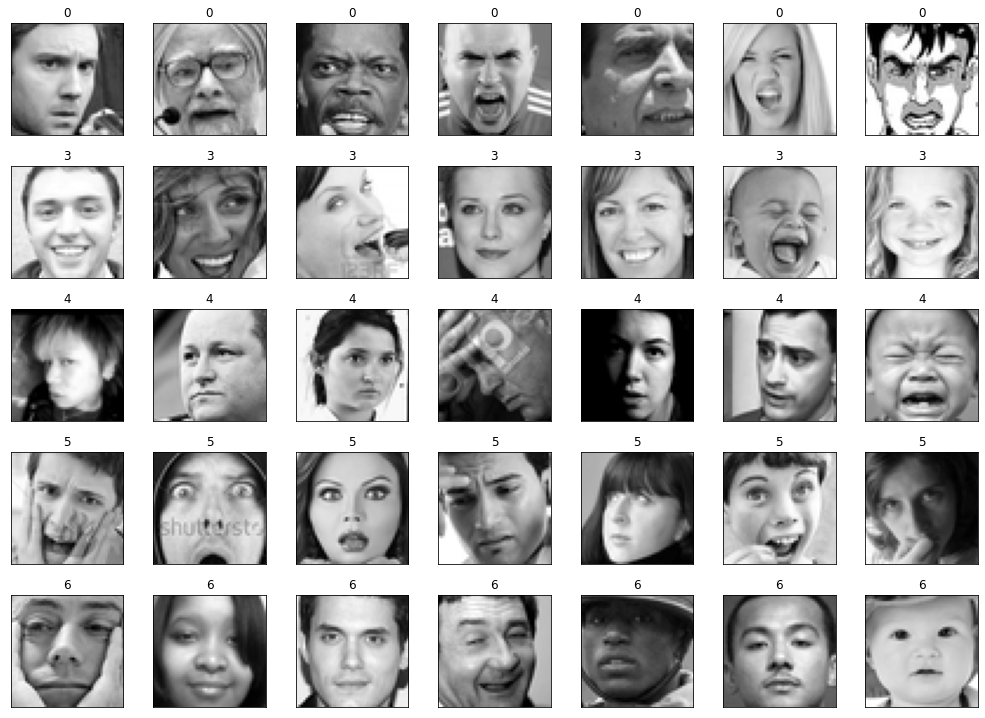

In [ ]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label)
        plt.tight_layout()

 check y labels

In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

Y labels can be interpreted as below:
*   0 & 1: Angry/ Annoyed
*   3: Happy
*   4: Sad
*   2 & 5: Surprised
*   6: neutral --> change to label 1



In [ ]:
data = df.copy() #just in case... make a copy of original data
df.emotion = df.emotion.replace(1,0) #combine label 1&0
df.emotion = df.emotion.replace(5,2) #combine label 2&5
df.emotion = df.emotion.replace(6,1) #change label 6 to 1
df.emotion.unique()

array([0, 2, 4, 1, 3])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


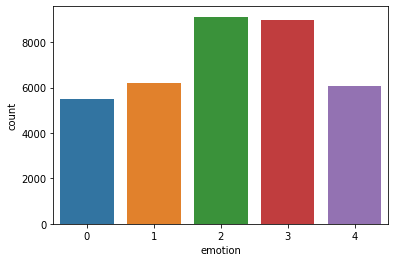

In [ ]:
sns.countplot(df.emotion);

In [ ]:
label = {0:'angry🤬', 1: 'neutral😐', 2:'surprised😱', 3:'happy🥳', 4: 'sad😥'}

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))/255
img_array = np.stack(img_array, axis=0)
img_array.shape

(35887, 48, 48, 1)

```
#Run this cell if you want to see how np.concatenate and np.stack is different!

print(df.pixels)
array1 = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
array2 = np.concatenate(array1, axis=0)
print(array1)
print(array2)
print(img_array)
```



>  **What is difference between stack and concatenate function?**

Basically, Stack function is same with concatnate added 'reshape' function. So concatenating joins arraies along a existing axis - so dimension remains same as before. Stacking joins arraies along a new axis so it's more like arrange two arraies side by side along the new axis.

If we concatenating img_array in the above cell, we will get (1722576,48, 1) shape of array (35,887(=total number of datas) x 48 (pixels) = 1,722,576). Since we need to arrange 35,887pcs of images side by side, we use np.stack instead of np.concatenate!





**CONCAT**

<p align="center">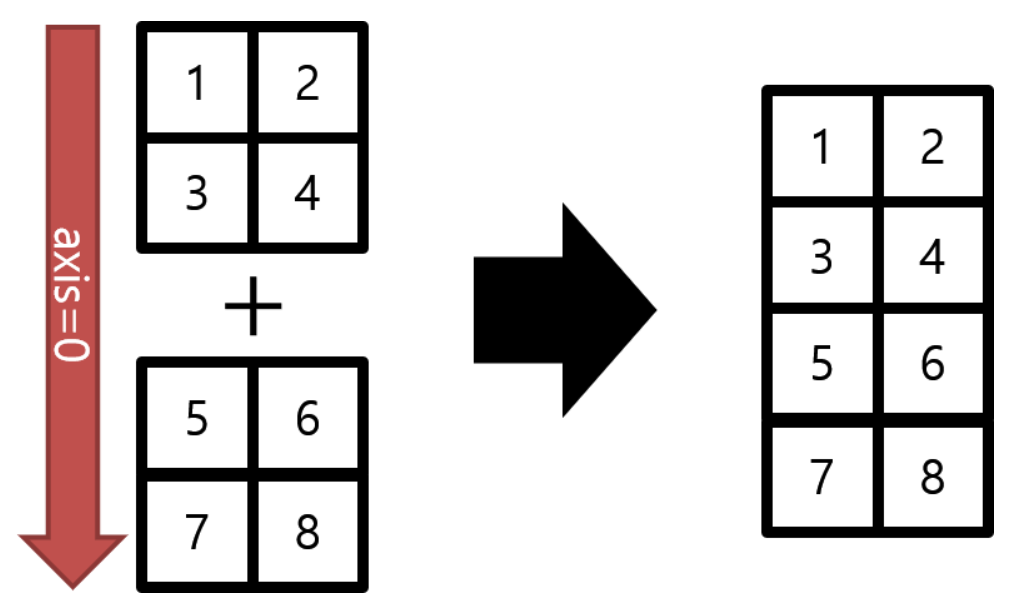</p>

**STACK**

<p align="center">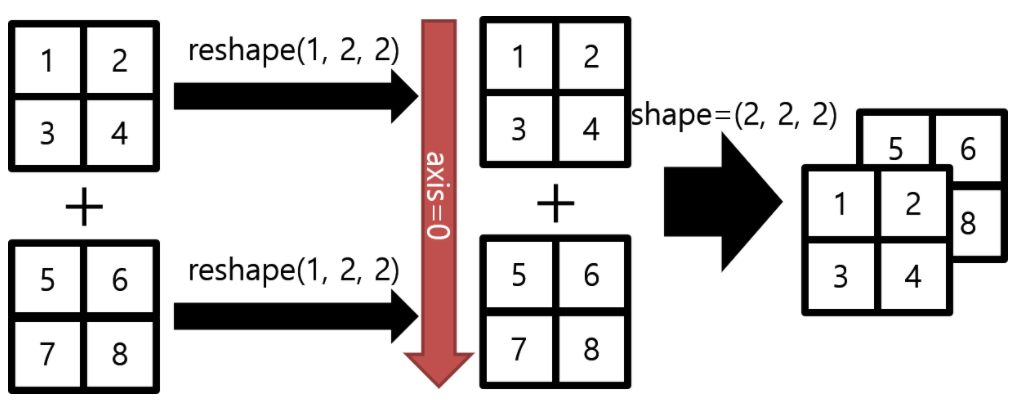</p>

Change labels to one-hot vectors

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 5)

Keep which label is mapped to each vector

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


Split train/test dataset

In [ ]:
X_train, X, y_train, y = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.3, random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X, y,
                                                    shuffle=True, stratify=y,
                                                    test_size=0.5, random_state=10)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((25120, 48, 48, 1),
 (5383, 48, 48, 1),
 (5384, 48, 48, 1),
 (25120, 5),
 (5383, 5),
 (5384, 5))

###3) Dataset for SVM

We need to make X and y labels for SVM separately since SVM only accpets 2dim for X and 1dim for y.

In [ ]:
img_array_sne = df.pixels.apply(lambda x: np.array(x.split(' ')).astype('float32'))/255
img_array_sne = np.stack(img_array_sne, axis=0)
img_array_sne.shape

(35887, 2304)

In [ ]:
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=3, init='pca', random_state=0, verbose=0, n_iter=300)
time_start = time.time()
X_tsne = tsne.fit_transform(img_array_sne)
print('t-SNE is done. Time elapsed:{} seconds'.format(time.time()-time_start))

Computing t-SNE embedding
t-SNE is done. Time elapsed:7861.718724727631 seconds


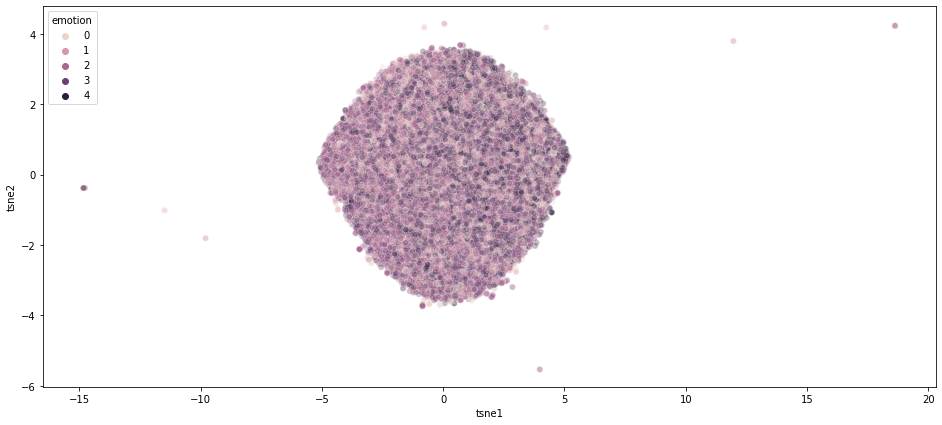

In [ ]:
df_tsne=df.copy()
df_tsne['tsne1']=X_tsne[:,0]
df_tsne['tsne2']=X_tsne[:,1]
plt.figure(figsize=(16,7))
sns.scatterplot(
    x='tsne1',
    y='tsne2',
    hue='emotion',
    data=df_tsne,
    legend='full',
    alpha=0.3
)
plt.show()

In [ ]:
X_train_svm, X, y_train_svm, y = train_test_split(X_tsne, df.emotion, 
                                                    shuffle=True, stratify=df.emotion,
                                                    test_size=0.3, random_state=10)
X_val_svm, X_test_svm, y_val_svm, y_test_svm = train_test_split(X, y,
                                                    shuffle=True, stratify=y,
                                                    test_size=0.5, random_state=10)
X_train_svm.shape, X_val_svm.shape, X_test_svm.shape, y_train_svm.shape, y_val_svm.shape, y_test_svm.shape

((25120, 3), (5383, 3), (5384, 3), (25120,), (5383,), (5384,))

###4) Dataset for Bidrectional LSTM

❓ Why LSTM need different dimension of dataset

In [ ]:
img_array_lstm = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(1, 48, 48, 1).astype('float32'))/255
img_array_lstm = np.stack(img_array_lstm, axis=0)
img_array_lstm.shape

(35887, 1, 48, 48, 1)

In [ ]:
X_train_lstm, X, y_train_lstm, y = train_test_split(img_array_lstm, img_labels, 
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.3, random_state=10)
X_val_lstm, X_test_lstm, y_val_lstm, y_test_lstm = train_test_split(X, y,
                                                    shuffle=True, stratify=y,
                                                    test_size=0.5, random_state=10)
X_train_lstm.shape, X_val_lstm.shape, X_test_lstm.shape, y_train_lstm.shape, y_val_lstm.shape, y_test_lstm.shape

((25120, 1, 48, 48, 1),
 (5383, 1, 48, 48, 1),
 (5384, 1, 48, 48, 1),
 (25120, 5),
 (5383, 5),
 (5384, 5))

###5) Dataset for Transfer learning

In [ ]:
def preprocess_input(x):
    x -= np.mean(x)
    return x

def get_data(dataset):
    file_stream = file_io.FileIO(dataset, mode='r')
    data = pd.read_csv(file_stream)
    pixels = data['pixels'].tolist()
    images = np.empty((len(data), img_height, img_width, 3))
    i = 0

    for pixel_sequence in pixels:
        single_image = [float(pixel) for pixel in pixel_sequence.split(' ')]
        single_image = np.asarray(single_image).reshape(48, 48)
        single_image = resize(single_image, (img_height, img_width), order = 3, mode = 'constant')
        ret = np.empty((img_height, img_width, 3))  
        ret[:, :, 0] = single_image
        ret[:, :, 1] = single_image
        ret[:, :, 2] = single_image
        images[i, :, :, :] = ret
        i += 1
    
    images = preprocess_input(images)

    return images

In [ ]:
# Data preparation
img_height, img_width = 48 , 48
img_array_tf = get_data('./fer2013/fer2013/fer2013.csv')
img_array_tf.shape

(35887, 48, 48, 3)

In [ ]:
X_train_tf, X, y_train_tf, y = train_test_split(img_array_tf, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.3, random_state=10)
X_val_tf, X_test_tf, y_val_tf, y_test_tf = train_test_split(X, y,
                                                    shuffle=True, stratify=y,
                                                    test_size=0.5, random_state=10)
X_train_tf.shape, X_val_tf.shape, X_test_tf.shape, y_train_tf.shape, y_val_tf.shape, y_test_tf.shape

((25120, 48, 48, 3),
 (5383, 48, 48, 3),
 (5384, 48, 48, 3),
 (25120, 5),
 (5383, 5),
 (5384, 5))

###6) Issues

This dataset has following problems:

*   **Class imbalance**

  There is an imbalance between classes. It became better than the original dataset after combining class 1 & 0 and 2& 5, and  we can mitigate it more by data augmentation.

*   **Intra-class variation**

 Some datas are real photos but some are cartoons. We can solve this problem by avoiding over-fitting.


*   **Eye glasses**

 Some peoples are wearing glasses even eyes are really important factor to detect emotion. 


##2-2. Modeling

###1) SVM

In [ ]:
c_vals=[1, 5, 10, 100, 300, 1000]
gamma_vals=[1, 0.1, 0.01, 0.0001, 0.00001]

param_random = [
  {'C': c_vals, 'gamma': gamma_vals},
  ]

svc = RandomizedSearchCV(SVC(kernel='rbf',decision_function_shape='ovr'), param_random, n_jobs=-1, cv=3, scoring='accuracy')
start_time = time.time()
svc.fit(X_train_svm, y_train_svm)

print(svc.best_estimator_)
print('train score:', svc.score(X_train_svm, y_train_svm))
val_score= svc.score(X_val_svm, y_val_svm)
print('validation score:',val_score)
print('time:',time.time()-start_time)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
train score: 0.3368232484076433
validation score: 0.3106074679546721
time: 3836.885904073715


Tuning the hyper-parameters

In [ ]:
c_vals=[1, 3, 5]
gamma_vals=[1,0.3,'auto']

param_grid = [
  {'C': c_vals, 'gamma': gamma_vals},
  ]

svc = GridSearchCV(SVC(kernel='rbf',decision_function_shape='ovr'), param_grid, n_jobs=-1, cv=5, scoring='accuracy')

start_time = time.time()
svc.fit(X_train_svm, y_train_svm)
print('time:',time.time()-start_time)

print(svc.best_estimator_)
print('train score:', svc.score(X_train_svm, y_train_svm))
val_score= svc.score(X_val_svm, y_val_svm)
print('validation score:',val_score)

time: 1652.082754611969
SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
train score: 0.344984076433121
validation score: 0.3107932379713914


In [ ]:
print('test score:',svc.score(X_test_svm, y_test_svm))

test score: 0.3220653789004458


###2) DCNN

I used 'Elu' as an activation fuction for hidden layers. What different from Leaky Relu is Elu has non-linear shape of graph under 0.

**Pros**

*   ELU becomes smooth slowly until its output equal to -α whereas RELU sharply smoothes.
*   ELU is a strong alternative to ReLU.

*   Unlike to ReLU, ELU can produce negative outputs.

**Cons**

*   For x > 0, it can blow up the activation with the output range of [0, inf].

<p align="center">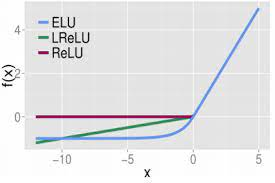</p>

In [ ]:
def build_dcnn(input_shape, show_arch=True):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=input_shape,
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            5,
            activation='softmax',
            name='out_layer'
        )
    )

    if show_arch:
        net.summary()
    return net

I used two call backs to avoid overfitting - early_stopping and ReduceLROnPlateau.
ReduceLROnPlateau monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced sothat we can escape a local minimum.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

In [ ]:
batch_size = 32
optimizer = optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam')
 
model = build_dcnn((48,48,1))
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=100,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


785/785 [==============================] - 19s 20ms/step - loss: 2.1367 - accuracy: 0.2515 - val_loss: 1.4609 - val_accuracy: 0.3845
Epoch 2/100
785/785 [==============================] - 16s 20ms/step - loss: 1.5160 - accuracy: 0.3510 - val_loss: 1.3230 - val_accuracy: 0.4618
Epoch 3/100
785/785 [==============================] - 16s 20ms/step - loss: 1.3676 - accuracy: 0.4298 - val_loss: 1.2553 - val_accuracy: 0.4995
Epoch 4/100
785/785 [==============================] - 15s 20ms/step - loss: 1.2660 - accuracy: 0.4835 - val_loss: 1.1153 - val_accuracy: 0.5577
Epoch 5/100
785/785 [==============================] - 16s 20ms/step - loss: 1.2054 - accuracy: 0.5123 - val_loss: 1.0778 - val_accuracy: 0.5670
Epoch 6/100
785/785 [==============================] - 16s 20ms/step - loss: 1.1519 - accuracy: 0.5397 - val_loss: 1.0669 - val_accuracy: 0.5781
Epoch 7/100
785/785 [==============================] - 16s 20ms/step - loss: 1.1164 - accuracy: 0.5555 - val_loss: 1.0384 - val_accuracy: 0.59

In [ ]:
model_yaml = model.to_yaml()
with open("model_DCNN.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model_DCNN.h5")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

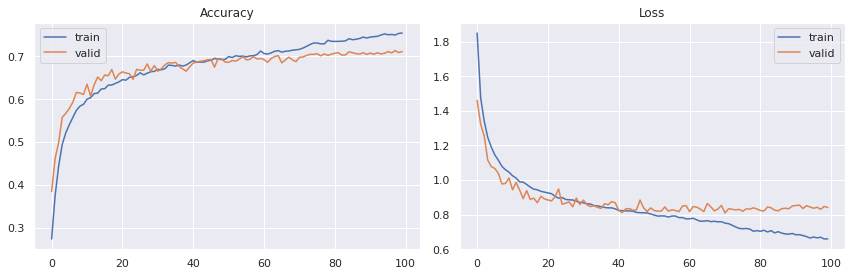

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.show();

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129395 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129324 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129395 missing from current font.
  font.set_text(s, 0, flags=flags)


total wrong test predictions: 1553


              precision    recall  f1-score   support

           0       0.65      0.68      0.66       825
           1       0.60      0.70      0.65       930
           2       0.77      0.69      0.73      1369
           3       0.86      0.87      0.86      1349
           4       0.59      0.56      0.57       911

    accuracy                           0.71      5384
   macro avg       0.69      0.70      0.70      5384
weighted avg       0.72      0.71      0.71      5384



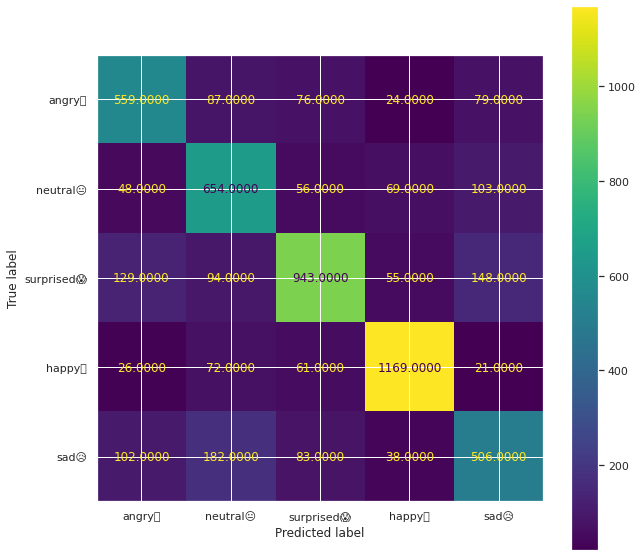

In [ ]:
from sklearn.metrics import classification_report

yhat_test = np.argmax(model.predict(X_test), axis=-1)

cm = confusion_matrix(np.argmax(y_test, axis=1), yhat_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label.values()))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(include_values=True, values_format='.4f', ax=ax)
plt.savefig("confusion_matrix_dcnn.png")

print(f'total wrong test predictions: {np.sum(np.argmax(y_test, axis=1) != yhat_test)}\n\n')
print(classification_report(np.argmax(y_test, axis=1), yhat_test))

###3) DCNN + LSTM

It is known that the generation of facial expression involves movements of several organs such as eyebrows, eyes and lips, which are also described as action units (AUs). More AUs will be involved as the facial expression becomes more complicated. In this letter, some researchers investigated the facial
expression recognition problem by leveraging the correlations between AUs and learning the spatial dependency information among different image regions through long short-term memory (LSTM) and found the accuracy was better than DNN models.





*   keras.TimeDistributed: This function is used for many-to-many LSTM models. It allows to apply a layer to every temporal slice of an input. Cost(error) is calcualated at each step and the cost propagates to the lower steps as if each step is connected with FC.

(For more explanation in Korean - please click 👉 [here](https://m.blog.naver.com/chunjein/221589624838))
*   List item





In [ ]:
def build_dcnn(input_shape, show_arch=True):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            input_shape=input_shape,
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.45, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.45, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.4, name='dropout_3'))

    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_7'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_8'
        )
    )
    net.add(BatchNormalization(name='batchnorm_8'))
    
    net.add(Dropout(0.4, name='dropout_4'))
    
    net.add(GlobalMaxPool2D(name="globalmax2d"))
    
    if show_arch:
        net.summary()
    
    return net

In [ ]:
def memory_model(input_shape, num_class=5, show_arch=True):
    dcnn = build_dcnn(input_shape[1:], show_arch=False) #The model definded above (show_arch=False: to do not print model.summary of DCNN model)
    
    model = Sequential(name="convolutional_Bidrectional_LSTM")

    model.add(
        TimeDistributed(
            dcnn,
            input_shape=input_shape,
            name="time_distributed",
        )
    )
    
    model.add(Bidirectional(LSTM(128, return_sequences=True, name="bidirect_lstm_1")))
    model.add(Dropout(.35, name="dropout_1"))
    model.add(Bidirectional(LSTM(64, return_sequences=False, name="bidirect_lstm_2")))
    model.add(Dropout(.45, name="dropout_2"))

    model.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    model.add(BatchNormalization(name='batchnorm_1'))
    model.add(Dropout(.7, name="dropout_3"))

    model.add(
        Dense(
            num_class,
            activation='softmax',
            name='out_layer'
        )
    )
    
    if show_arch:
        model.summary()
    
    return model

set call backs again

In [ ]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

In [ ]:
INPUT_SHAPE = (1, 48, 48, 1)
batch_size = 32
optim = optimizers.Nadam(0.001)

model = memory_model(INPUT_SHAPE, num_class=5)
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

Model: "convolutional_Bidrectional_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 1, 512)            4691904   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1, 256)            656384    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None,

In [ ]:
history = model.fit(
    x=X_train_lstm,
    y=y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    batch_size=batch_size,
    epochs=100,
    callbacks=lr_scheduler,
    use_multiprocessing=True
)

Epoch 1/100
785/785 [==============================] - 32s 34ms/step - loss: 1.9822 - accuracy: 0.2279 - val_loss: 1.5722 - val_accuracy: 0.2889
Epoch 2/100
785/785 [==============================] - 24s 31ms/step - loss: 1.5812 - accuracy: 0.2841 - val_loss: 1.5556 - val_accuracy: 0.3110
Epoch 3/100
785/785 [==============================] - 24s 31ms/step - loss: 1.5138 - accuracy: 0.3532 - val_loss: 1.3916 - val_accuracy: 0.4143
Epoch 4/100
785/785 [==============================] - 24s 31ms/step - loss: 1.4072 - accuracy: 0.4133 - val_loss: 1.3203 - val_accuracy: 0.4602
Epoch 5/100
785/785 [==============================] - 24s 31ms/step - loss: 1.3122 - accuracy: 0.4494 - val_loss: 1.3622 - val_accuracy: 0.4276
Epoch 6/100
785/785 [==============================] - 24s 31ms/step - loss: 1.2795 - accuracy: 0.4618 - val_loss: 1.1840 - val_accuracy: 0.4774
Epoch 7/100
785/785 [==============================] - 24s 31ms/step - loss: 1.2631 - accuracy: 0.4613 - val_loss: 1.1695 - val_ac

In [ ]:
model_yaml = model.to_yaml()
with open("model_LSTM.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model_LSTM.h5")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

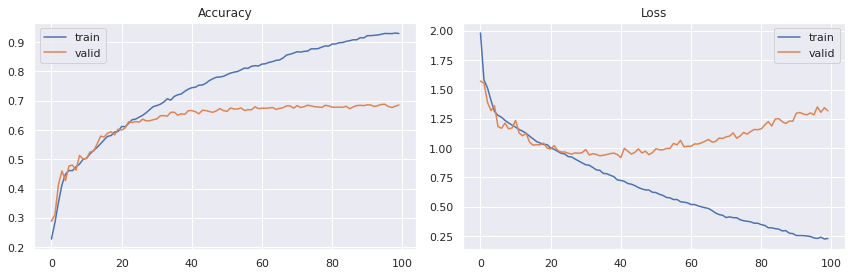

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129395 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129324 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129395 missing from current font.
  font.set_text(s, 0, flags=flags)


total wrong test predictions: 1720


              precision    recall  f1-score   support

           0       0.63      0.60      0.61       825
           1       0.55      0.67      0.61       930
           2       0.81      0.65      0.72      1369
           3       0.83      0.86      0.84      1349
           4       0.51      0.56      0.53       911

    accuracy                           0.68      5384
   macro avg       0.67      0.67      0.66      5384
weighted avg       0.69      0.68      0.68      5384



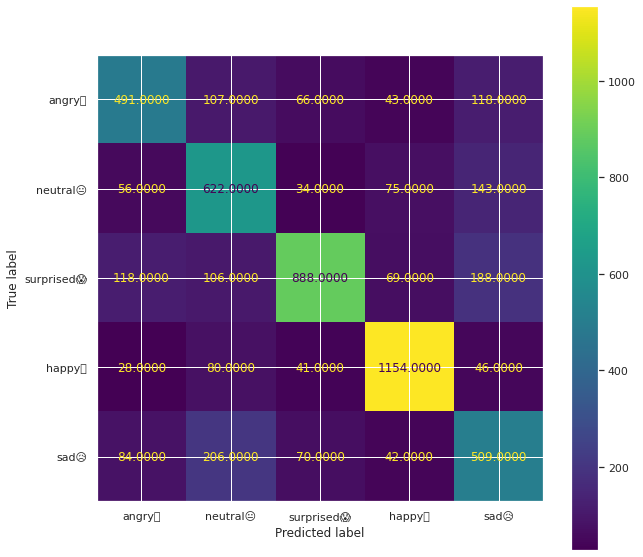

In [ ]:
yhat_test = np.argmax(model.predict(X_test_lstm), axis=-1)

cm = confusion_matrix(np.argmax(y_test_lstm, axis=1), yhat_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label.values()))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(include_values=True, values_format='.4f', ax=ax)
plt.savefig("confusion_matrix_lstm.png")

print(f'total wrong test predictions: {np.sum(np.argmax(y_test_lstm, axis=1) != yhat_test)}\n\n')
print(classification_report(np.argmax(y_test_lstm, axis=1), yhat_test))

###4) Transfer learning

####4-1) MobileNet

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet

17227776/17225924 [==============================] - 0s 0us/step


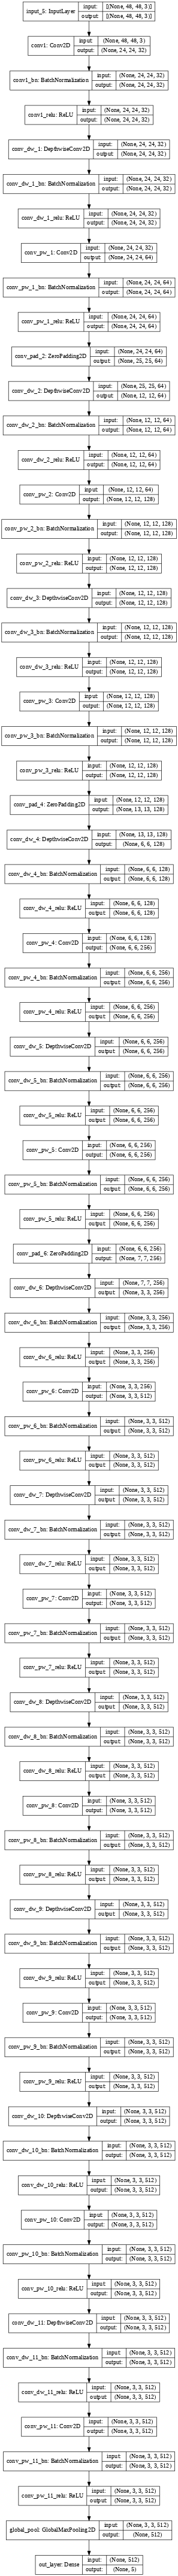

In [ ]:
num_classes = 5

mobile_net = MobileNet(
    input_shape = (48, 48, 3),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

for layer in model.layers[:15]:
    layer.trainable = False

plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet.png')

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)

train_datagen.fit(X_train_tf)

In [ ]:
batch_size = 32
epochs = 100

optim = optimizers.Adam(0.01)

model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

history = model.fit_generator(
    train_datagen.flow(X_train_tf, y_train_tf, batch_size=batch_size),
    validation_data=(X_val_tf, y_val_tf),
    steps_per_epoch=len(X_train_tf) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
785/785 [==============================] - 29s 34ms/step - loss: 1.0733 - accuracy: 0.5729 - val_loss: 1.2870 - val_accuracy: 0.5031
Epoch 2/100
785/785 [==============================] - 26s 33ms/step - loss: 1.0850 - accuracy: 0.5710 - val_loss: 1.1013 - val_accuracy: 0.5543
Epoch 3/100
785/785 [==============================] - 26s 33ms/step - loss: 1.0903 - accuracy: 0.5662 - val_loss: 1.0724 - val_accuracy: 0.5709
Epoch 4/100
785/785 [==============================] - 26s 33ms/step - loss: 1.0864 - accuracy: 0.5647 - val_loss: 1.0963 - val_accuracy: 0.5662
Epoch 5/100
785/785 [==============================] - 26s 33ms/step - loss: 1.0823 - accuracy: 0.5678 - val_loss: 1.1101 - val_accuracy: 0.5397
Epoch 6/100
785/785 [==============================] - 26s 33ms/step - loss: 1.0806 - accuracy: 0.5669 - val_loss: 1.1095 - val_accuracy: 0.5495
Epoch 7/100
785/785 [==============================] - 26s 32ms/step - loss: 1.0838 - accuracy: 0.5700 - val_loss: 1.1206 - val_ac

In [ ]:
model_yaml = model.to_yaml()
with open("model_mobelnet.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model_moblenet.h5")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

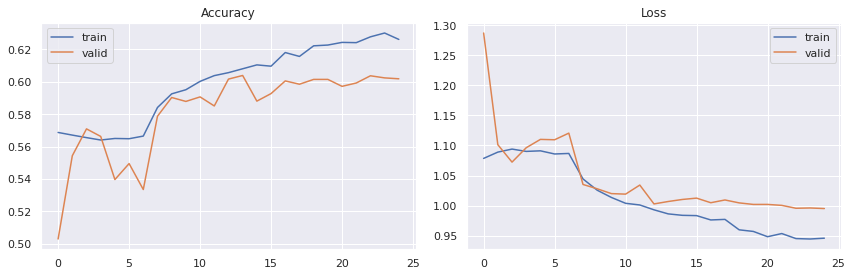

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_mobilenet.png')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129395 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129324 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129395 missing from current font.
  font.set_text(s, 0, flags=flags)


total wrong validation predictions: 2164


              precision    recall  f1-score   support

           0       0.51      0.44      0.48       825
           1       0.47      0.62      0.54       930
           2       0.65      0.63      0.64      1369
           3       0.81      0.78      0.80      1349
           4       0.44      0.40      0.42       911

    accuracy                           0.60      5384
   macro avg       0.58      0.57      0.57      5384
weighted avg       0.60      0.60      0.60      5384



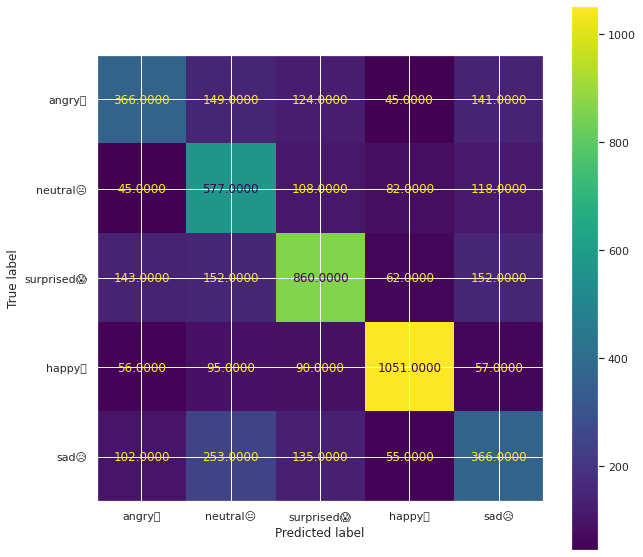

In [ ]:
yhat_valid = np.argmax(model.predict(X_test_tf), axis=-1)

cm = confusion_matrix(np.argmax(y_test_tf, axis=1), yhat_valid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label.values()))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(include_values=True, values_format='.4f', ax=ax)
plt.savefig("confusion_matrix_mobilenet.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_test_tf, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_test_tf, axis=1), yhat_valid))

####4-2) Resnet50 + VGGFace2

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights='imagenet')

In [ ]:
folder = 'logs/ResNet-50'

# Parameters
num_classes         = 5
epochs_top_layers   = 10
epochs_all_layers   = 100
batch_size          = 32

Because Resnet model's input size is 197x197, we need to add zero pedding layer to uppooling the image size from 48x48

In [ ]:
base_model = Sequential()                                                                                                                                                                              
base_model.add(ZeroPadding2D((133, 133), input_shape=(48, 48, 3)))
base_model.add(VGGFace(model= 'resnet50',include_top = False,weights= 'vggface'))

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_input (InputL [(None, 48, 48, 3)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 314, 314, 3)       0         
_________________________________________________________________
vggface_resnet50 (Functional (None, None, None, 2048)  23561152  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 25,664,453
Trainable params: 25,611,333
Non-trainable params: 53,120
____________________________________________

In [ ]:
#Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range  = 10,
    shear_range     = 10,
    zoom_range      = 0.1,
    fill_mode       = 'reflect',
    horizontal_flip = True)

# Takes numpy data & label arrays, and generates batches of augmented/normalized data. Yields batcfillhes indefinitely, in an infinite loop
    # x:            Data. Should have rank 4. In case of grayscale data, the channels axis should have value 1, and in case of RGB data, it should have value 3
    # y:            Labels
    # batch_size:   Int (default: 32)
train_generator = train_datagen.flow(
    X_train_tf,
    y_train_tf,
    batch_size  = batch_size)

Train upper layers
*   Train only the top layers (which were randomly initialized) freezing all convolutional ResNet-50 layers


In [ ]:
#freezing RasNet-50
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer   = Adam(lr = 1e-3, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0), 
    loss        = 'categorical_crossentropy', 
    metrics     = ['accuracy'])

In [ ]:
# This callback writes a log for TensorBoard, which allows you to visualize dynamic graphs of your training and test metrics, as well as activation histograms for the different layers in your model
    # log_dir:          The path of the directory where to save the log files to be parsed by TensorBoard
    # histogram_freq:   Frequency (in epochs) at which to compute activation and weight histograms for the layers of the model
    #                   If set to 0, histograms won't be computed. Validation data (or split) must be specified for histogram visualizations
    # write_graph:      Whether to visualize the graph in TensorBoard. The log file can become quite large when write_graph is set to True
    # write_grads:      Whether to visualize gradient histograms in TensorBoard. histogram_freq must be greater than 0
    # write_images:     Whether to write model weights to visualize as image in TensorBoard
# To visualize the files created during training, run in your terminal: tensorboard --logdir path_to_current_dir/Graph
folder = 'ResNet-50'

tensorboard_top_layers = TensorBoard(
	log_dir         = folder + '/logs_top_layers',
	histogram_freq  = 0,
	write_graph     = True,
	write_grads     = False,
	write_images    = True)

In [ ]:
model.fit_generator(
    generator = train_generator,
    steps_per_epoch = len(X_train_tf) // batch_size,
    epochs = epochs_top_layers,                            
    validation_data = (X_val_tf, y_val_tf),
    callbacks = [tensorboard_top_layers])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
785/785 [==============================] - 169s 213ms/step - loss: 1.6381 - accuracy: 0.2944 - val_loss: 1.5403 - val_accuracy: 0.3296
Epoch 2/10
785/785 [==============================] - 171s 217ms/step - loss: 1.5178 - accuracy: 0.3432 - val_loss: 1.5066 - val_accuracy: 0.3543
Epoch 3/10
785/785 [==============================] - 171s 217ms/step - loss: 1.5083 - accuracy: 0.3504 - val_loss: 1.5298 - val_accuracy: 0.3234
Epoch 4/10
785/785 [==============================] - 170s 217ms/step - loss: 1.4995 - accuracy: 0.3546 - val_loss: 1.5075 - val_accuracy: 0.3485
Epoch 5/10
785/785 [==============================] - 171s 217ms/step - loss: 1.4915 - accuracy: 0.3587 - val_loss: 1.5140 - val_accuracy: 0.3362
Epoch 6/10
785/785 [==============================] - 170s 217ms/step - loss: 1.4823 - accuracy: 0.3600 - val_loss: 1.4977 - val_accuracy: 0.3645
Epoch 7/10
785/785 [==============================] - 171s 218ms/step - loss: 1.4733 - accuracy: 0.3720 - val_loss: 1.4917 -

Train full network


*   At this point, the top layers are well trained and we can start fine-tuning convolutional layers from ResNet-50



In [ ]:
# Fine-tuning of all the layers
for layer in model.layers:
    layer.trainable = True

model.compile(
    optimizer   = SGD(lr = 1e-4, momentum = 0.9, decay = 0.0, nesterov = True),
    loss        = 'categorical_crossentropy', 
    metrics     = ['accuracy'])

Define tensorboard again for the log of training all layers

In [ ]:
tensorboard_all_layers = TensorBoard(
    log_dir         = folder + '/logs_all_layers',
    histogram_freq  = 0,
    write_graph     = True,
    write_grads     = False,
    write_images    = True)

Defind callback functions
*   At this time, we will try validation loss as a moniter indicator instead of validation accuracy because accuracy is not always a good indicator because of its yes or no nature



In [ ]:
#Learning rate scheduler per epoch
def scheduler(epoch):
    updated_lr = K.get_value(model.optimizer.lr) * 0.5
    if (epoch % 3 == 0) and (epoch != 0):
        K.set_value(model.optimizer.lr, updated_lr)
        print(K.get_value(model.optimizer.lr))
    return K.get_value(model.optimizer.lr)

reduce_lr = LearningRateScheduler(scheduler)

# Reduce learning rate when a metric has stopped improving
reduce_lr_plateau = ReduceLROnPlateau(
	monitor 	= 'val_loss',
	factor		= 0.5,
	patience	= 3,
	mode 		= 'auto',
	min_lr		= 1e-8)

# Stop training when a monitored quantity has stopped improving
early_stop = EarlyStopping(
	monitor 	= 'val_loss',
	patience 	= 10,
	mode 		= 'auto')

train the model - all layers

In [ ]:
history = model.fit_generator(
    generator           = train_generator,
    steps_per_epoch     = len(X_train_tf) / batch_size,
    epochs              = epochs_all_layers,                        
    validation_data     = (X_val_tf, y_val_tf),
    callbacks           = [tensorboard_all_layers, reduce_lr, reduce_lr_plateau, early_stop])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
785/785 [==============================] - 517s 650ms/step - loss: 1.8227 - accuracy: 0.3409 - val_loss: 1.3362 - val_accuracy: 0.4490
Epoch 2/100
785/785 [==============================] - 509s 649ms/step - loss: 1.2980 - accuracy: 0.4601 - val_loss: 1.2281 - val_accuracy: 0.5007
Epoch 3/100
785/785 [==============================] - 508s 648ms/step - loss: 1.1700 - accuracy: 0.5228 - val_loss: 1.1243 - val_accuracy: 0.5437
Epoch 4/100
5e-05
785/785 [==============================] - 509s 648ms/step - loss: 1.1017 - accuracy: 0.5595 - val_loss: 1.0911 - val_accuracy: 0.5586
Epoch 5/100
785/785 [==============================] - 509s 649ms/step - loss: 1.0604 - accuracy: 0.5779 - val_loss: 1.0835 - val_accuracy: 0.5605
Epoch 6/100
785/785 [==============================] - 510s 649ms/step - loss: 1.0381 - accuracy: 0.5818 - val_loss: 1.0629 - val_accuracy: 0.5686
Epoch 7/100
2.5e-05
785/785 [==============================] - 509s 648ms/step - loss: 0.9971 - accuracy: 0.6019

Save model

In [ ]:
model_yaml = model.to_yaml()
with open("model_Resnet.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model_resnet.h5")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

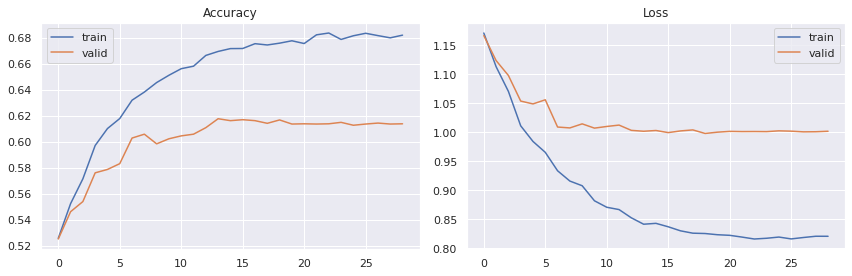

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_resnet.png')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129395 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129324 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129395 missing from current font.
  font.set_text(s, 0, flags=flags)


total wrong test predictions: 2073


              precision    recall  f1-score   support

           0       0.50      0.52      0.51       825
           1       0.52      0.59      0.55       930
           2       0.67      0.65      0.66      1369
           3       0.78      0.80      0.79      1349
           4       0.48      0.41      0.44       911

    accuracy                           0.61      5384
   macro avg       0.59      0.59      0.59      5384
weighted avg       0.61      0.61      0.61      5384



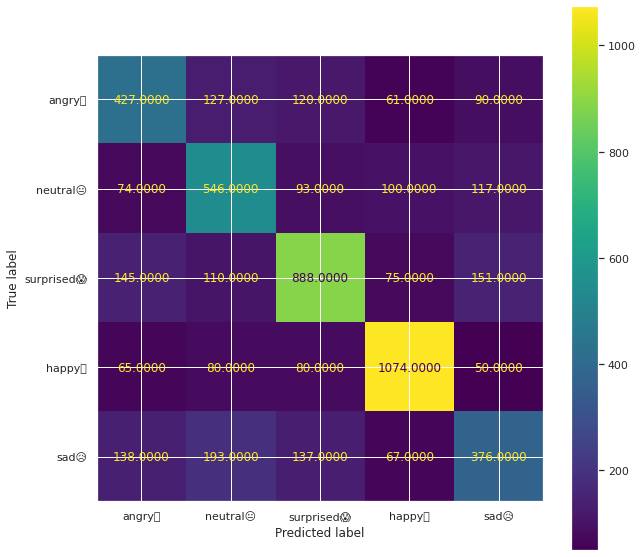

In [ ]:
yhat_test = np.argmax(model.predict(X_test_tf), axis=-1)

cm = confusion_matrix(np.argmax(y_test_tf, axis=1), yhat_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label.values()))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(include_values=True, values_format='.4f', ax=ax)
plt.savefig("confusion_matrix_resnet.png")

print(f'total wrong test predictions: {np.sum(np.argmax(y_test_tf, axis=1) != yhat_test)}\n\n')
print(classification_report(np.argmax(y_test_tf, axis=1), yhat_test))

####4-3) Xception

In [ ]:
# parameters
batch_size = 32
num_epochs = 110
input_shape = (48, 48, 1)
verbose = 1
num_classes = 5
patience = 50
base_path = 'Xception/'
l2_regularization=0.01
 
# model parameters
regularization = l2(l2_regularization)

In [ ]:
# base
img_input = layers.Input(input_shape)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
 
# module 1
residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 2
residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 3
residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 4
residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
x = Conv2D(num_classes, (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax',name='predictions')(x)
 
model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 46, 46, 8)    72          input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 46, 46, 8)    32          conv2d_17[0][0]                  
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 46, 46, 8)    0           batch_normalization_31[0][0]     
____________________________________________________________________________________________

Defind path for call back results for Xception model

In [ ]:
# callbacks
log_file_path = base_path + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = base_path + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

In [ ]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [ ]:
history = model.fit_generator(data_generator.flow(X_train, y_train, batch_size),
                        steps_per_epoch=len(X_train) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(X_val,y_val))

Epoch 1/110
  4/785 [..............................] - ETA: 17s - loss: 1.4021 - accuracy: 0.3984

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


785/785 [==============================] - 18s 22ms/step - loss: 1.3574 - accuracy: 0.4596 - val_loss: 1.4641 - val_accuracy: 0.4115

Epoch 00001: val_loss improved from inf to 1.46408, saving model to Xception/_mini_XCEPTION.01-0.41.hdf5
Epoch 2/110
785/785 [==============================] - 18s 22ms/step - loss: 1.2571 - accuracy: 0.5009 - val_loss: 1.2637 - val_accuracy: 0.5079

Epoch 00002: val_loss improved from 1.46408 to 1.26366, saving model to Xception/_mini_XCEPTION.02-0.51.hdf5
Epoch 3/110
785/785 [==============================] - 18s 23ms/step - loss: 1.1935 - accuracy: 0.5299 - val_loss: 1.1390 - val_accuracy: 0.5634

Epoch 00003: val_loss improved from 1.26366 to 1.13898, saving model to Xception/_mini_XCEPTION.03-0.56.hdf5
Epoch 4/110
785/785 [==============================] - 18s 22ms/step - loss: 1.1524 - accuracy: 0.5477 - val_loss: 1.2110 - val_accuracy: 0.5278

Epoch 00004: val_loss did not improve from 1.13898
Epoch 5/110
785/785 [==============================] -

In [ ]:
model_yaml = model.to_yaml()
with open("model_Xception.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model_Xception.h5")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

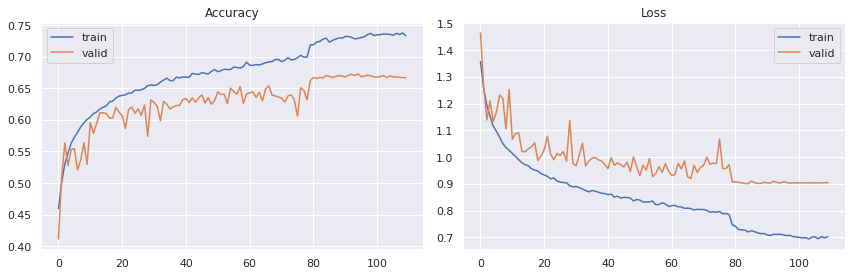

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_xception.png')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129395 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129324 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129395 missing from current font.
  font.set_text(s, 0, flags=flags)


total wrong test predictions: 1765


              precision    recall  f1-score   support

           0       0.58      0.62      0.60       825
           1       0.57      0.64      0.60       930
           2       0.73      0.67      0.70      1369
           3       0.85      0.83      0.84      1349
           4       0.53      0.52      0.53       911

    accuracy                           0.67      5384
   macro avg       0.65      0.66      0.65      5384
weighted avg       0.68      0.67      0.67      5384



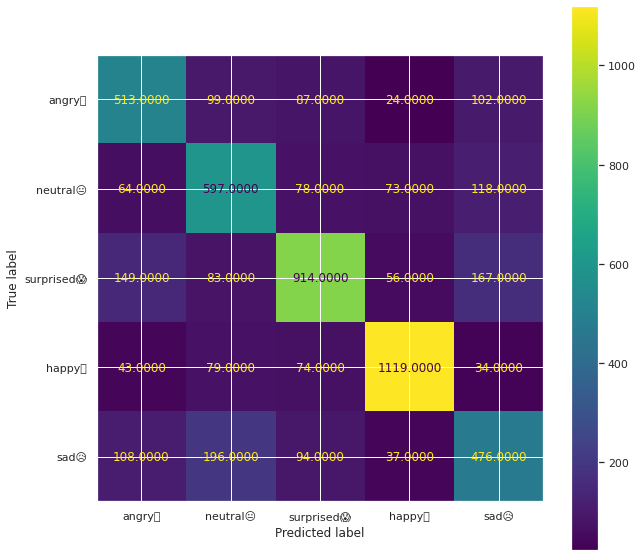

In [ ]:
yhat_test = np.argmax(model.predict(X_test), axis=-1)

cm = confusion_matrix(np.argmax(y_test, axis=1), yhat_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label.values()))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(include_values=True, values_format='.4f', ax=ax)
plt.savefig("confusion_matrix_xception.png")

print(f'total wrong test predictions: {np.sum(np.argmax(y_test, axis=1) != yhat_test)}\n\n')
print(classification_report(np.argmax(y_test, axis=1), yhat_test))

###5) library

This is facial emotion detecting library. The result shows prediction percentage per emotion class in list as below


> [{'box': [277, 90, 48, 63], 'emotions': {'angry': 0.02, 'disgust': 0.0, 'fear': 0.05, 'happy': 0.16, 'neutral': 0.09, 'sad': 0.27, 'surprise': 0.41}]



In [ ]:
!pip install fer
!pip install tensorflow>=1.7 opencv-contrib-python==3.3.0.9
!pip install tensorflow-gpu\>=1.7.0

In [ ]:
from fer import FER
import cv2

def prediction(X):
  preds = []
  detector = FER(mtcnn=True) #using OpenCV's Haar Cascade classifier
  for array in X_test:
    img = cv2.imread(array)
    emotion, score = detector.top_emotion(img)
    if emotion == 'angry' or emotion == 'disgust':
      pred = 0
    elif emotion == 'neutral':
      pred = 1
    elif emotion == 'fear' or 'surprise':
      pred = 2
    elif emotion == 'happy':
      pred = 3
    elif emotion == 'sad':
      pred = 4
    preds.append([pred])
  return preds  

In [ ]:
from fer import Video
from fer import FER

video_filename = "tests/woman2.mp4"
video = Video(video_filename)

# Analyze video, displaying the output
detector = FER(mtcnn=True)
raw_data = video.analyze(detector, display=True)
df = video.to_pandas(raw_data)

#3. Results

In [ ]:
mymodel=

In [ ]:
np.random.seed(0)
indices = np.random.choice(range(X_test.shape[0]), size=15, replace=False)

fig = pyplot.figure(1, (9,30))

i = 0
for idx in indices:
    true_emotion = label[np.argmax(y_test[idx])]
    pred_emotion = label[model.predict_classes(np.expand_dims(X_test[idx], axis=0))[0]]
    
    for j in range(3):
        i += 1
        ax = pyplot.subplot(15,3,i)
        sample_img = X_valid[idx,j,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:{true_emotion}, p:{pred_emotion}")

In [ ]:
import cv2 # pip install opencv-python
from keras.preprocessing.image import img_to_array
import imutils
import cv2
from keras.models import load_model
import numpy as np

# parameters for loading data and images
#pip install opencv-contrib-python full package
#from deepface import DeepFace #pip install deepface
detection_model_path = 'haarcascade_files/haarcascade_frontalface_default.xml'
emotion_model_path = 'models/_mini_XCEPTION.106-0.65.hdf5'

# hyper-parameters for bounding boxes shape
# loading models
face_detection = cv2.CascadeClassifier(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
EMOTIONS = {'angry🤬', 'neutral😐', 'surprised😱', 'happy🥳', 'sad😥'}

#4. Reference


*   [HUMAN EMOTION RECOGNITION USING MACHINE LEARNING](https://education.dellemc.com/content/dam/dell-emc/documents/en-us/2019KS_Nannapaneni-Human_Emotion_Recognition_using_Machine_Learning.pdf)  (2019)
*   [A Joint Convolutional Bidirectional LSTM Framework for Facial
Expression Recognition](https://www.jstage.jst.go.jp/article/transinf/E101.D/4/E101.D_2017EDL8208/_pdf) (2018)
*   [Strengths and Weaknesses of Deep Learning Models
for Face Recognition Against Image Degradations](https://arxiv.org/pdf/1710.01494.pdf) (2017)
*   [Real-time Convolutional Neural Networks for
Emotion and Gender Classification](https://arxiv.org/pdf/1710.07557.pdf) (2017)
*  [Multimodal-Emotion-Recognition](https://github.com/maelfabien/Multimodal-Emotion-Recognition)  - Github
*  [XiuweiHe/EmotionClassifier](https://github.com/XiuweiHe/EmotionClassifier)  - Github
*   [Demonstration of Facial Emotion Recognition on Real Time Video Using CNN : Python & Keras](https://appliedmachinelearning.blog/2018/11/28/demonstration-of-facial-emotion-recognition-on-real-time-video-using-cnn-python-keras/)
*  [FER](https://pypi.org/project/fer/) - Pypi
